# Interpolation vs Extrapolation: Polynomial Regression vs Neural Network

This notebook accompanies the subsection on **Interpolation vs Extrapolation** in Chapter 4
of the *Mathematics of Generative AI* living book.

We compare:

1. **Polynomial regression** of varying degrees.
2. **A simple neural network with one hidden layer** (tanh activation).

Our goals are to:

- Illustrate how high-degree polynomials overfit (oscillate) in the interpolation regime,
  especially when the polynomial degree exceeds the number of data points.
- Show that a neural network with many parameters can smoothly interpolate the data without
  developing such oscillations.
- Demonstrate that **both** models fail to extrapolate reliably outside the training region.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# Ensure the figs directory exists
os.makedirs("figs", exist_ok=True)

# For reproducibility
np.random.seed(0)
torch.manual_seed(0)


## 1. Target Function and Training Data

We consider a smooth one-dimensional target function
\( f: \mathbb{R} \to \mathbb{R} \). For concreteness, we use
\[
f(x) = \mathrm{e}^{-x^2} \cos(3x),
\]
which is clearly non-polynomial but smooth.

We will:

- Sample a **small number** of training points (e.g., `n_train = 5`) in the interval
  \([-1, 1]\). This is the **interpolation region**.
- Study model behavior both inside this region and outside (extrapolation) on a wider
  interval (e.g., \([-2, 2]\)).


In [2]:
def f_true(x):
    return np.exp(-x**2) * np.cos(3.0 * x)

# Training data
n_train = 5
x_train = np.linspace(-1.0, 1.0, n_train)
y_train = f_true(x_train)

# Test / visualization grid (wider domain for extrapolation)
x_plot = np.linspace(-2.0, 2.0, 400)
y_plot_true = f_true(x_plot)

n_train, x_train, y_train[:3]


(5,
 array([-1. , -0.5,  0. ,  0.5,  1. ]),
 array([-0.36419789,  0.05509019,  1.        ]))

### Visualization of Training Data and True Function

We plot the true function on a wide interval together with the few training points.
This highlights the difference between the interpolation region and extrapolation region.


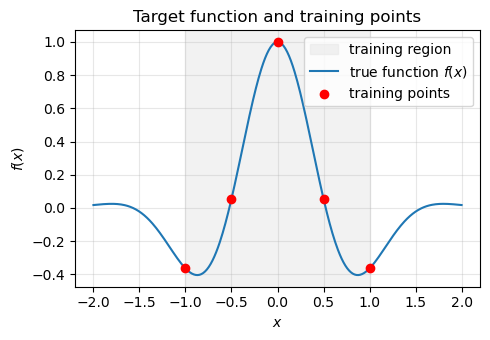

In [3]:
plt.figure(figsize=(5.0, 3.5))

# Shade the training region [-1,1]
plt.axvspan(-1.0, 1.0, color="0.9", alpha=0.5, label="training region")

plt.plot(x_plot, y_plot_true, label="true function $f(x)$")
plt.scatter(x_train, y_train, color="red", zorder=3, label="training points")

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Target function and training points")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/interpoly_true_and_data.png", dpi=300, bbox_inches="tight")
plt.show()


## 2. Polynomial Regression

We fit polynomials of increasing degree to the training data. Given \( n \) points
\((x_i, y_i)\), we consider polynomials of degree \(d\):
\[
P_d(x;w) = w_0 + w_1 x + \cdots + w_d x^d,
\]
with parameters \(w\) chosen by least squares (minimizing mean squared error).

We are particularly interested in the case where \(d > n - 1\), in which the polynomial
can interpolate all training points but may exhibit strong oscillations between and outside
those points.


In [4]:
def fit_poly(x, y, degree):
    # Uses numpy.polyfit, which returns coefficients in descending powers.
    coeffs = np.polyfit(x, y, degree)
    return coeffs

def eval_poly(coeffs, x):
    return np.polyval(coeffs, x)

degrees = [1, 3, 9]  # 1 < n-1, moderate, and > n-1 (since n_train=5 => n-1=4)
poly_coeffs = {d: fit_poly(x_train, y_train, d) for d in degrees}

# Evaluate on x_plot
poly_preds = {d: eval_poly(poly_coeffs[d], x_plot) for d in degrees}
poly_coeffs


/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_64804/2752819318.py:10: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = {d: fit_poly(x_train, y_train, d) for d in degrees}


{1: array([3.51083347e-17, 7.63569207e-02]),
 3: array([ 0.        , -1.01913483,  0.        ,  0.58592434]),
 9: array([ 4.12148484e-16,  1.36274211e+00, -1.68779789e-15,  1.10110627e+00,
         8.92554375e-16,  5.56066219e-02,  3.74886053e-16, -3.88365289e+00,
        -1.02691879e-15,  1.00000000e+00])}

### Polynomial Fits: Interpolation vs Overfitting

We now compare the polynomial fits of degrees 1, 3, and 9. Degree 9 exceeds `n_train - 1`:
it can interpolate all training points exactly but may overfit (oscillate) elsewhere.


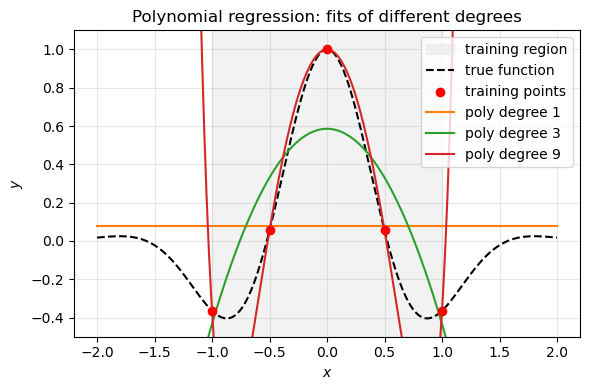

In [10]:
plt.figure(figsize=(6.0, 4.0))

plt.axvspan(-1.0, 1.0, color="0.9", alpha=0.5, label="training region")
plt.plot(x_plot, y_plot_true, "k--", label="true function")
plt.scatter(x_train, y_train, color="red", zorder=3, label="training points")

colors = ["C1", "C2", "C3"]
for d, c in zip(degrees, colors):
    plt.plot(x_plot, poly_preds[d], color=c, label=f"poly degree {d}")

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Polynomial regression: fits of different degrees")
plt.legend(loc="best")
plt.grid(alpha=0.3)

plt.ylim(-0.5, 1.1)


plt.tight_layout()
plt.savefig("figs/interpoly_poly_fits.png", dpi=300, bbox_inches="tight")
plt.show()


## 3. Neural Network with One Hidden Layer

We now consider a simple fully connected network:
- one scalar input,
- one hidden layer with \(h\) neurons and `tanh` activation,
- one scalar output.

The model can be written as
\[
\hat{y}(x) = W_{\text{out}} \tanh(W_{\text{hidden}} x + b_{\text{hidden}}) + b_{\text{out}}.
\]

The total number of trainable parameters is \(2h + 2\), which can be much larger than
the number of training samples \(n_{\text{train}}\).

We investigate what happens as we increase \(h\).


In [6]:
class Simple1DNN(nn.Module):
    def __init__(self, hidden_dim=50):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

    def predict(self, x_np):
        x_t = torch.tensor(x_np.reshape(-1, 1), dtype=torch.float32)
        with torch.no_grad():
            y_t = self.forward(x_t)
        return y_t.numpy().reshape(-1)

# Prepare tensors
x_train_t = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)


### Training the Neural Network

We train the network using the mean squared error (MSE) loss and the Adam optimizer.
To emphasize interpolation behavior, we train long enough so that the network fits the few
training points very well.


In [7]:
hidden_dim = 50  # number of hidden units (2h+2 parameters >> n_train)
model = Simple1DNN(hidden_dim=hidden_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

n_epochs = 5000
loss_history = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}: loss = {loss.item():.6f}")


Epoch 1000: loss = 0.000000
Epoch 2000: loss = 0.000000
Epoch 3000: loss = 0.000000
Epoch 4000: loss = 0.000000
Epoch 5000: loss = 0.000011


### Training Loss History

We first examine the training loss as a function of the number of epochs.


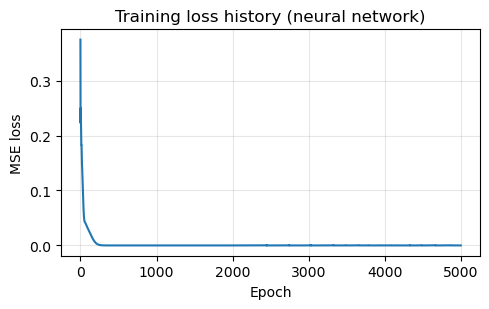

In [8]:
plt.figure(figsize=(5.0, 3.2))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training loss history (neural network)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/interpoly_nn_loss.png", dpi=300, bbox_inches="tight")
plt.show()


### Neural Network Fit: Interpolation and Extrapolation

We now compare the neural network's prediction with the true function on the wide interval
\([-2, 2]\). As before, we highlight the training region \([-1, 1]\).


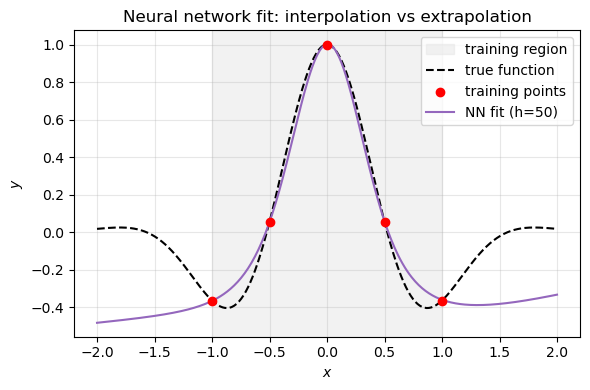

In [9]:
y_nn_plot = model.predict(x_plot)

plt.figure(figsize=(6.0, 4.0))
plt.axvspan(-1.0, 1.0, color="0.9", alpha=0.5, label="training region")
plt.plot(x_plot, y_plot_true, "k--", label="true function")
plt.scatter(x_train, y_train, color="red", zorder=3, label="training points")
plt.plot(x_plot, y_nn_plot, "C4", label=f"NN fit (h={hidden_dim})")

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Neural network fit: interpolation vs extrapolation")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/interpoly_nn_fit.png", dpi=300, bbox_inches="tight")
plt.show()


## 4. Discussion

From the figures, we observe:

- **Interpolation regime (inside \([-1, 1]\))**:
  - A high-degree polynomial (degree 9) passes exactly through all training points but
    exhibits strong oscillations between them.
  - The neural network, even with many parameters, tends to produce a much smoother fit
    without such oscillations.
- **Extrapolation regime (outside \([-1, 1]\))**:
  - Both models deviate significantly from the true function.
  - Increasing polynomial degree or the number of hidden units does not fix the
    extrapolation problem by itself.

This illustrates two key points:
1. In the interpolation regime, neural networks can generalize smoothly, even when the
   number of parameters greatly exceeds the number of data points.
2. Both polynomial regression and neural networks are limited by their
   **inductive biases** and the information present in the training data; neither
   should be expected to extrapolate reliably far outside the training region without
   additional structure or prior knowledge.
